# Import and organize Data

In [140]:
import pandas as pd
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline as make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import plot_tree
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

In [83]:
pd.set_option('display.max_columns', None)

In [84]:
houses = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPrices/Data/iter-4/housing-classification-iter4.csv')

In [85]:
houses_all = houses.copy()

As you can see below, there are many categorical columns, which only have very few observations. Let us combine some of them to make the model more robust to overfitting. In best case at least 50 obervations. Maybe sometimes we can even drop one, where there are very few observations.

# Split Data

Only ever use on of the two below. Comment out the other.

In [86]:
X = houses_all.drop(columns='Expensive')
y = houses_all['Expensive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
correlation_matrix = X_train.select_dtypes(include=['float64', 'int64']).corr()

In [88]:
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix of Numerical Features')
# plt.show()

In [89]:
print(y_train.value_counts())

0    999
1    169
Name: Expensive, dtype: int64


# Encoding

## Find Categories, which can be sorted meaningfully

In [90]:
# Define the custom orders
order_ExterQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_ExterCond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtExposure = ['NA', 'No', 'Mn', 'Av', 'Gd']
order_BsmtFinType1 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_KitchenQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_FireplaceQu = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

# Setup the encoder
ordinal_enc = OrdinalEncoder(
    categories=[
        order_ExterQual, order_ExterCond, order_BsmtQual, order_BsmtCond,
        order_BsmtExposure, order_BsmtFinType1, order_KitchenQual, order_FireplaceQu
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

In [91]:
categoric_features_ordinal = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
    'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu'
]

In [92]:
all_categorical_cols = list(X_train.select_dtypes(include=["object"]))
categoric_features_onehot = list(set(all_categorical_cols) - set(categoric_features_ordinal))
numeric_features = list(X_train.select_dtypes(exclude=["object"]))

In [93]:
numeric_pipe = make_pipeline(
    SimpleImputer()
)

categoric_pipe_onehot = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False, drop='first', min_frequency=100, handle_unknown='infrequent_if_exist')
)

categoric_pipe_ordinal = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    ordinal_enc 
)

In [94]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, numeric_features),
        ("cat_pipe_onehot", categoric_pipe_onehot, categoric_features_onehot),
        ("cat_pipe_ordinal", categoric_pipe_ordinal, categoric_features_ordinal),
    ]
)

In [95]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('dtree', DecisionTreeClassifier())
])

In [96]:
# model_pipeline = make_pipeline(preprocessor, dtree)

In [97]:
#model_pipeline.fit(X_train, y_train)

# Refine Model

## Cross Validation

### Randomized Grid Search

In [98]:
param_grid = {
    "preprocessor__num_pipe__simpleimputer__strategy": ["mean", "median", "most_frequent"],
    "dtree__max_depth": range(2, 25),
    "dtree__min_samples_leaf": range(3, 30),
    "dtree__criterion": ["gini", "entropy"]
}

In [99]:
search = RandomizedSearchCV(
    model_pipeline,
    param_grid,
    n_iter=10000,
    cv=10,
    verbose=1,
    n_jobs=-2,
    random_state=42
)

In [100]:
search.fit(X_train, y_train)

Fitting 10 folds for each of 3726 candidates, totalling 37260 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 3726 is smaller than n_iter=10000. Running 3726 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merleste

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_pipe',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer())]),
                                                                               ['LotArea',
                                                                                'LotFrontage',
                                                                                'TotalBsmtSF',
                                                                                'BedroomAbvGr',
                                                                                'Fireplaces',
                                                                                'PoolArea',
                                                                                'GarageCars',
                                                                                'WoodDeckSF',
                                                                                'ScreenPorch']),
                                                                              ('cat_pipe_onehot',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(s...
                                                                                'FireplaceQu'])])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('dtree',
                                              DecisionTreeClassifier())]),
                   n_iter=10000, n_jobs=-2,
                   param_distributions={'dtree__criterion': ['gini', 'entropy'],
                                        'dtree__max_depth': range(2, 25),
                                        'dtree__min_samples_leaf': range(3, 30),
                                        'preprocessor__num_pipe__simpleimputer__strategy': ['mean',
                                                                                            'median',
                                                                                            'most_frequent']},
                   random_state=42, verbose=1)

In [101]:
search.best_score_

0.9246463306808135

In [102]:
y_train_pred = search.predict(X_train)

accuracy_score(y_train, y_train_pred)

0.9580479452054794

In [103]:
y_test_pred = search.predict(X_test)

accuracy_score(y_test, y_test_pred)

0.9486301369863014

In [104]:
search.best_params_

{'preprocessor__num_pipe__simpleimputer__strategy': 'most_frequent',
 'dtree__min_samples_leaf': 5,
 'dtree__max_depth': 11,
 'dtree__criterion': 'entropy'}

In [106]:
best_max_depth = search.best_params_['dtree__max_depth']
best_min_samples_leaf = search.best_params_['dtree__min_samples_leaf']

In [107]:
best_max_depth, best_min_samples_leaf

(11, 5)

### Grid Search

In [108]:
param_grid = {
    "preprocessor__num_pipe__simpleimputer__strategy": ["mean", "median", "most_frequent"],
    "dtree__max_depth": range(best_max_depth - 4, best_max_depth + 5),
    "dtree__min_samples_leaf": range(best_min_samples_leaf - 4, best_min_samples_leaf + 5),
    "dtree__criterion": ["gini", "entropy"]
}

In [109]:
search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=10,
    n_jobs=-2,
    verbose=1
)

In [110]:
search.fit(X_train, y_train)

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/py

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         ['LotArea',
                                                                          'LotFrontage',
                                                                          'TotalBsmtSF',
                                                                          'BedroomAbvGr',
                                                                          'Fireplaces',
                                                                          'PoolArea',
                                                                          'GarageCars',
                                                                          'WoodDeckSF',
                                                                          'ScreenPorch']),
                                                                        ('cat_pipe_onehot',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strateg...
                                                                          'BsmtExposure',
                                                                          'BsmtFinType1',
                                                                          'KitchenQual',
                                                                          'FireplaceQu'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('dtree', DecisionTreeClassifier())]),
             n_jobs=-2,
             param_grid={'dtree__criterion': ['gini', 'entropy'],
                         'dtree__max_depth': range(7, 16),
                         'dtree__min_samples_leaf': range(1, 10),
                         'preprocessor__num_pipe__simpleimputer__strategy': ['mean',
                                                                             'median',
                                                                             'most_frequent']},
             verbose=1)

In [111]:
search.best_score_

0.9238211022693783

In [112]:
y_train_pred = search.predict(X_train)

accuracy_score(y_train, y_train_pred)

0.940068493150685

In [113]:
y_test_pred = search.predict(X_test)

accuracy_score(y_test, y_test_pred)

0.9417808219178082

In [114]:
search.best_params_

{'dtree__criterion': 'entropy',
 'dtree__max_depth': 7,
 'dtree__min_samples_leaf': 8,
 'preprocessor__num_pipe__simpleimputer__strategy': 'mean'}

# Visualize Tree

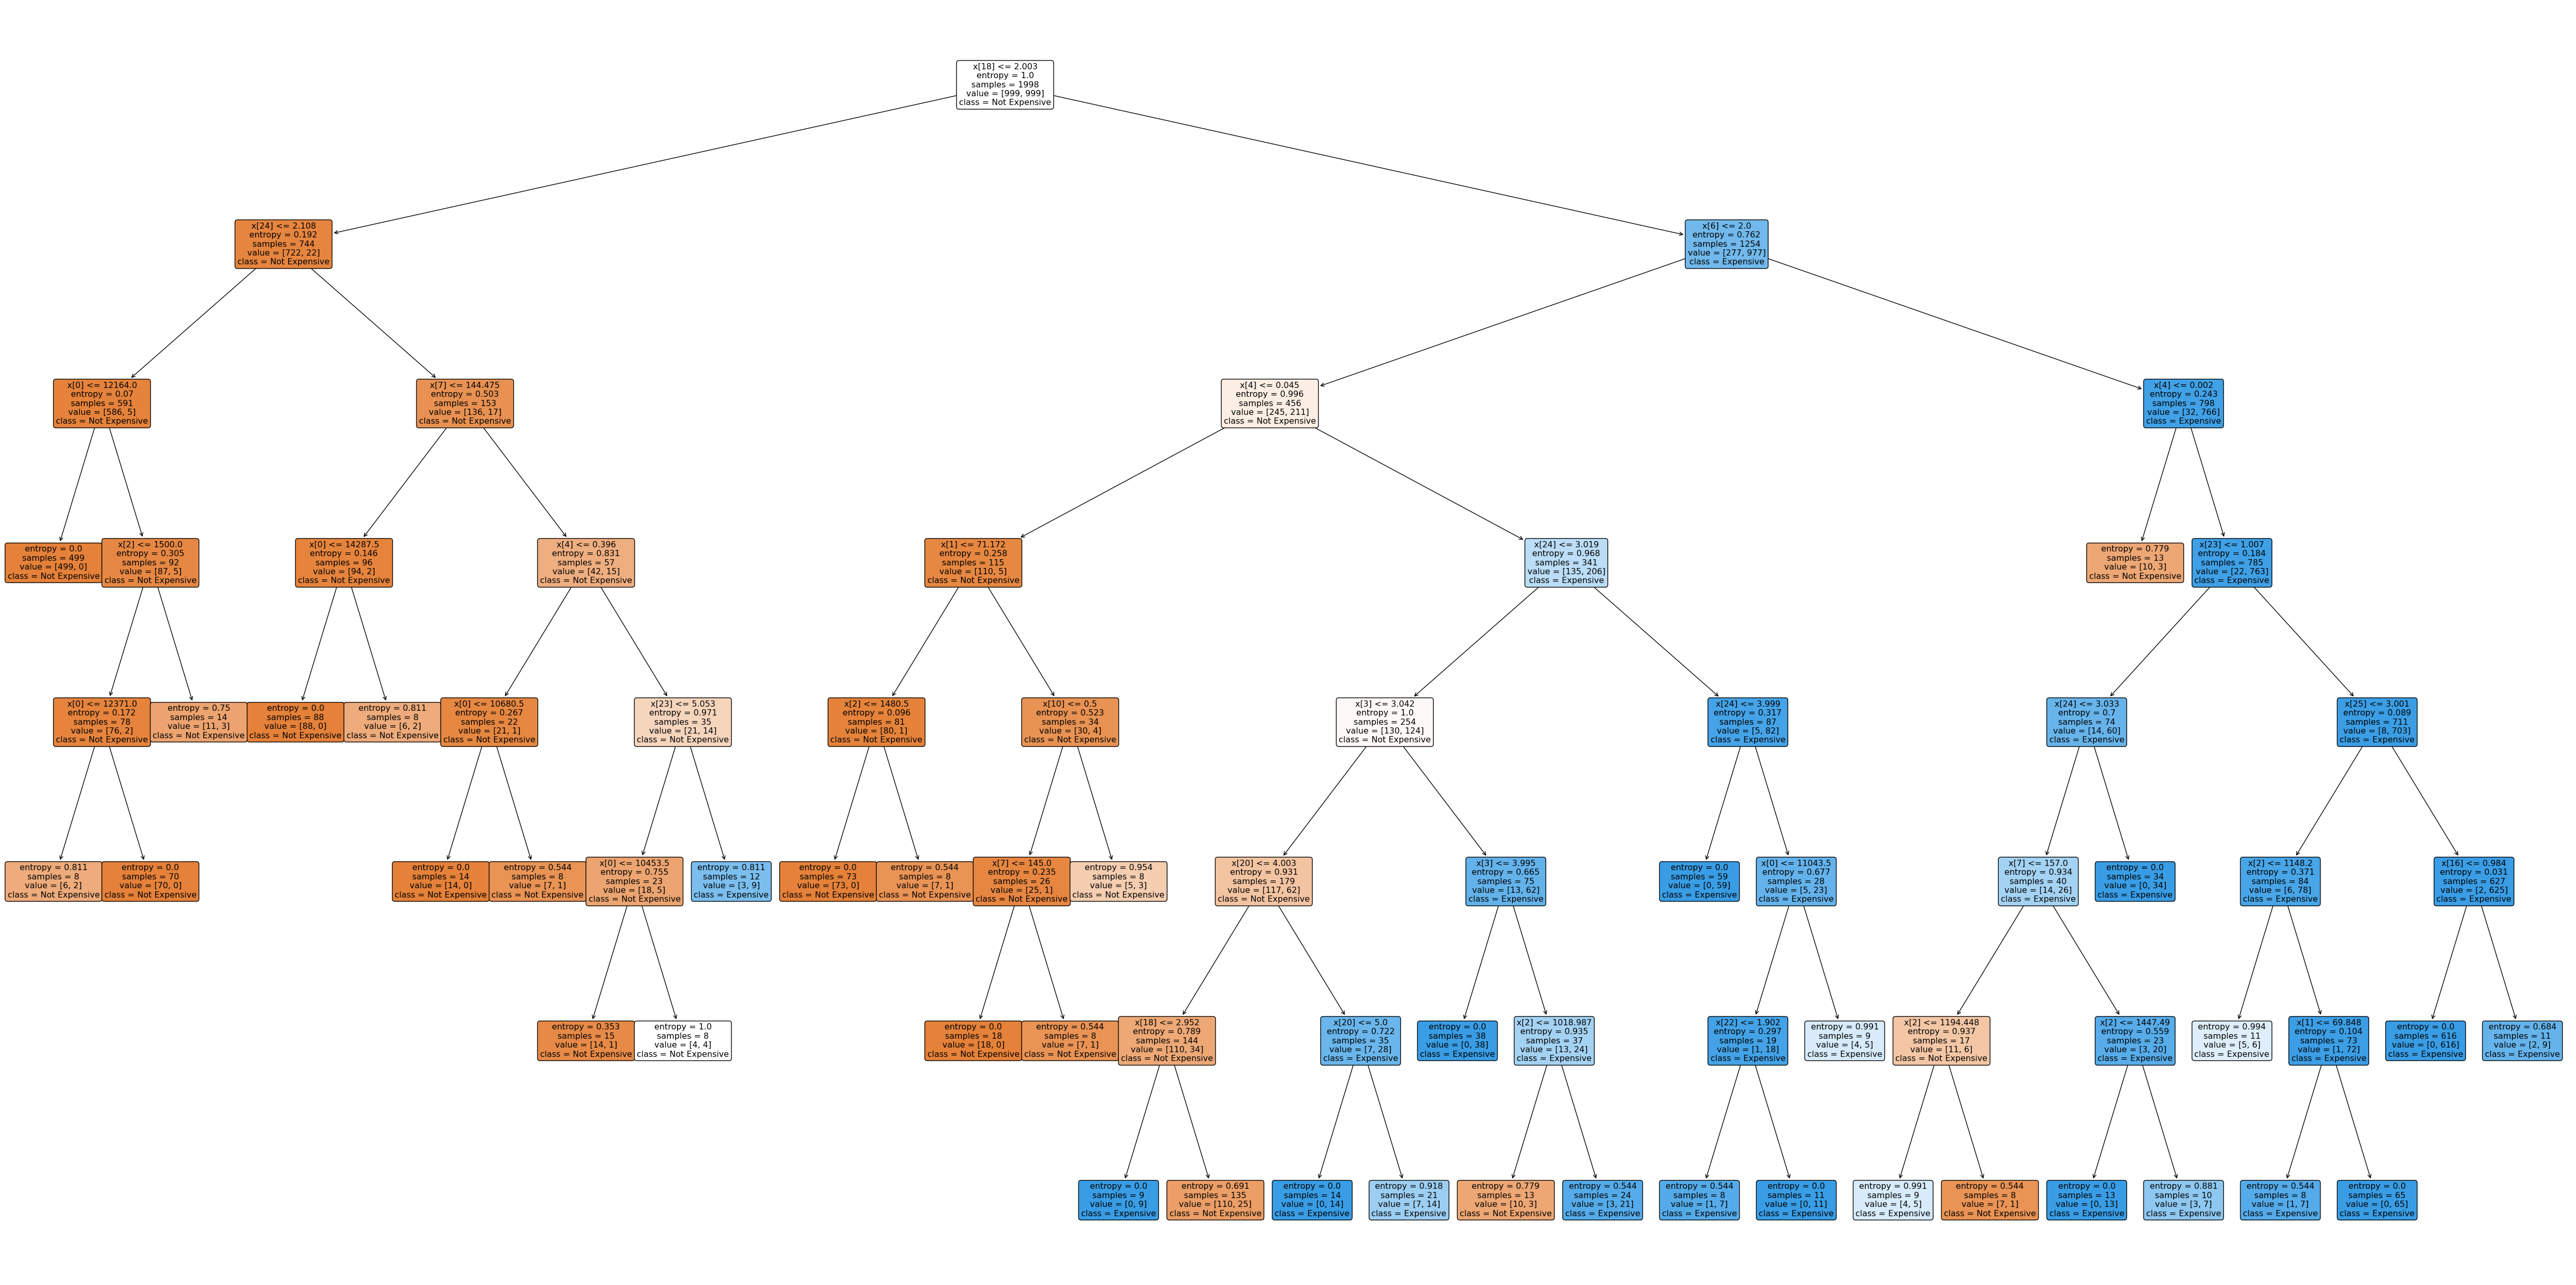

In [116]:
plt.figure(figsize=(64,32))
plot_tree(
    search.best_estimator_['dtree'],
    filled=True,
    rounded=True,
    class_names=['Not Expensive', 'Expensive']
)
plt.show();

# Classification performance metrics

## Confusion Matrix

In [121]:
y_train_pred = search.predict(X_train)
y_test_pred = search.predict(X_test)

In [130]:
cm = confusion_matrix(y_train, y_train_pred)

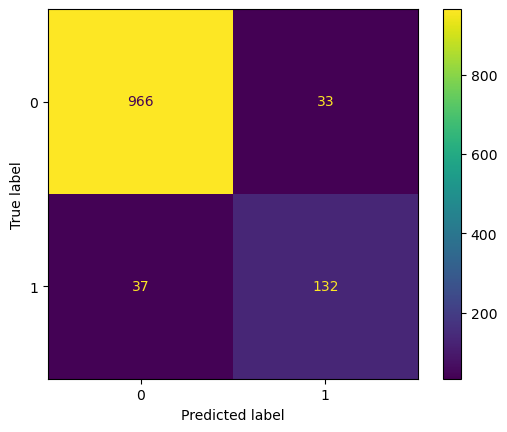

In [131]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=search.classes_)
disp.plot()

plt.show()

In [132]:
cm = confusion_matrix(y_test, y_test_pred)

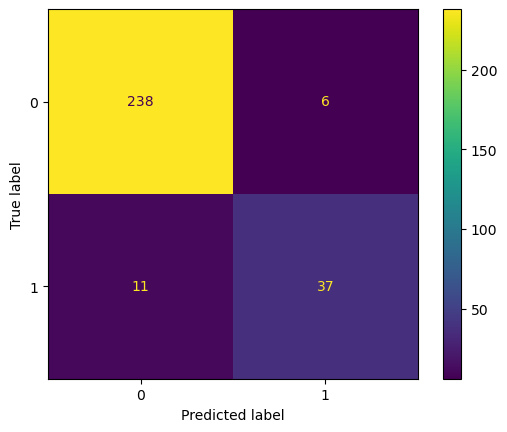

In [133]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=search.classes_)
disp.plot()

plt.show()

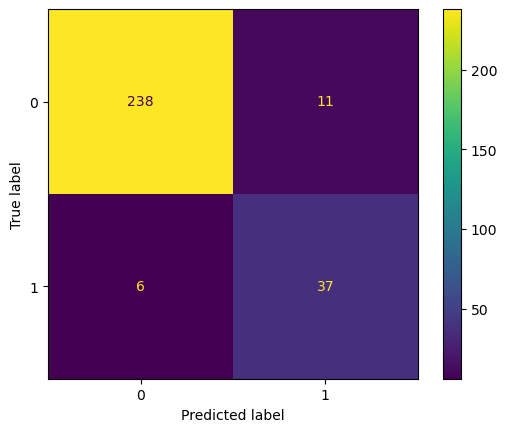

In [142]:
cm_transposed = cm.T
disp = ConfusionMatrixDisplay(confusion_matrix=cm_transposed,
                             display_labels=search.classes_)
disp.plot()

plt.show()

In [134]:
accuracy = (238 +37)/(238+6+11+37)
accuracy

0.9417808219178082

In [135]:
precision = 238/(238+37)
precision

0.8654545454545455

In [136]:
recall = 238/(238+6)
recall

0.9754098360655737

In [137]:
specificity = 37 / (11+37)
specificity

0.7708333333333334

In [138]:
F_1 = 2*((precision*recall)/(precision+recall))
F_1

0.9171483622350673

## Cohen’s Kappa Coefficient

In [141]:
kappa_score = cohen_kappa_score(y_test, y_test_pred)
print(kappa_score)

0.7788273035109606


# End

In [ ]:
print('This worked!')